Iniciando Análise Comparativa de 3 Modelos...
Carregando e analisando: MesoNet (Incompatível) (results.csv)...
Acurácia (HQ): 42.25% | Acurácia (LQ): 40.91%
AUC (HQ):      0.2767 | AUC (LQ):      0.2858
------------------------------
Carregando e analisando: XceptionNet (Pesado) (results_xception_TRAINADO.csv)...
Acurácia (HQ): 88.00% | Acurácia (LQ): 88.00%
AUC (HQ):      0.9733 | AUC (LQ):      0.9733
------------------------------
Carregando e analisando: MobileNetV2 (Leve) (results_mobilenet_TRAINADO.csv)...
Acurácia (HQ): 84.00% | Acurácia (LQ): 84.00%
AUC (HQ):      0.9609 | AUC (LQ):      0.9609
------------------------------

GRÁFICOS SENDO GERADOS...


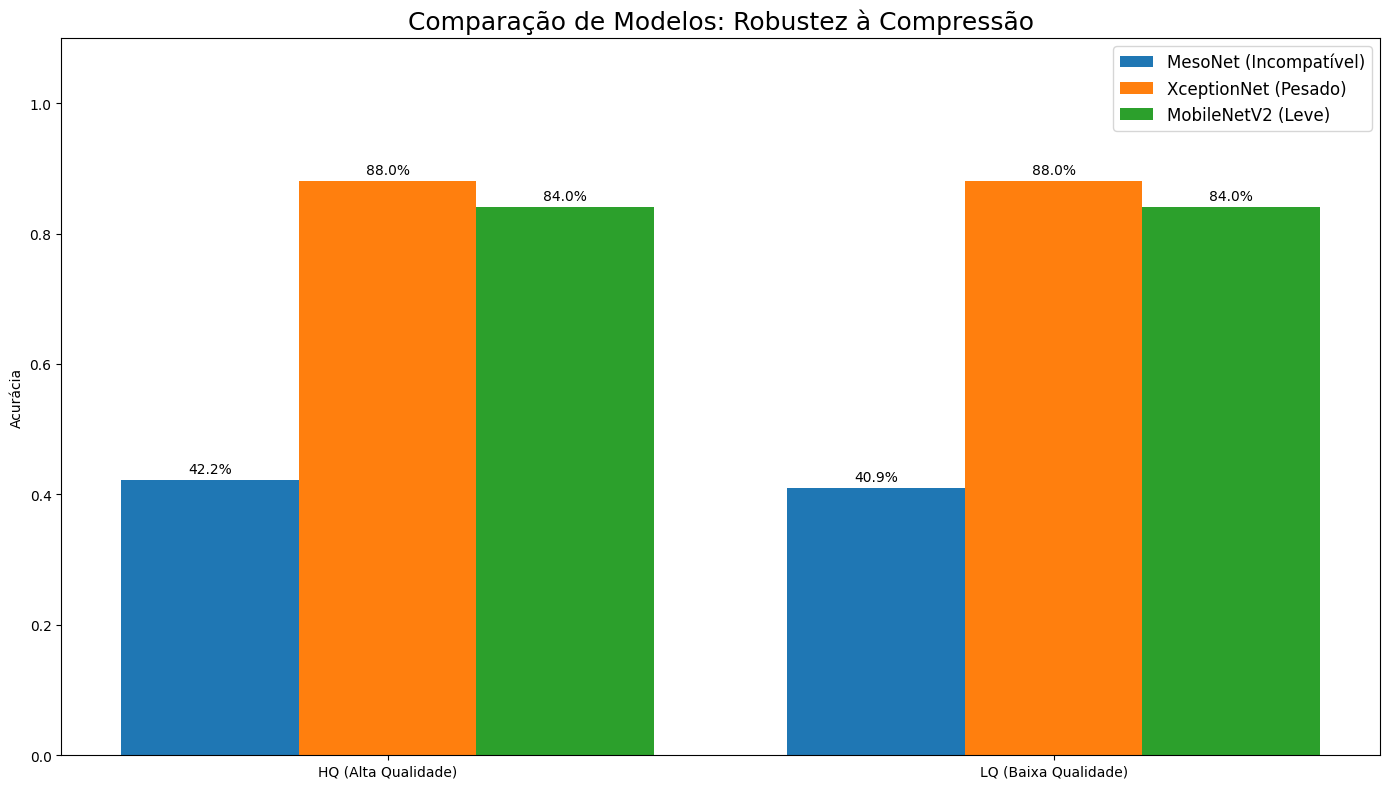


Gerando Gráfico 2: Histograma de Scores (O Raio-X)...


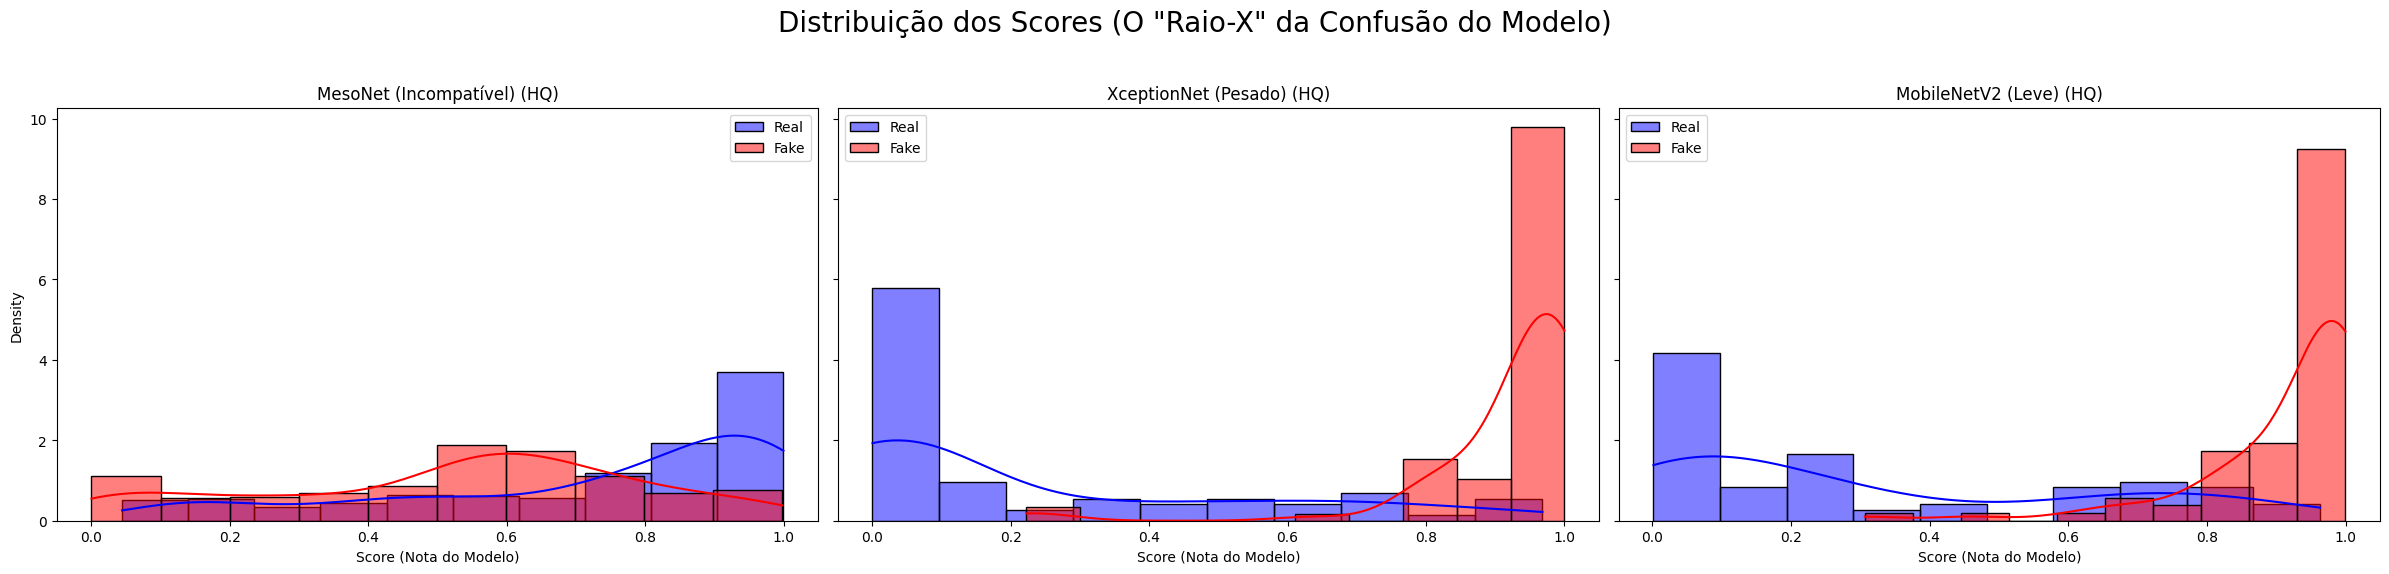


Gerando Gráfico 3: Curva ROC (O Padrão-Ouro)...


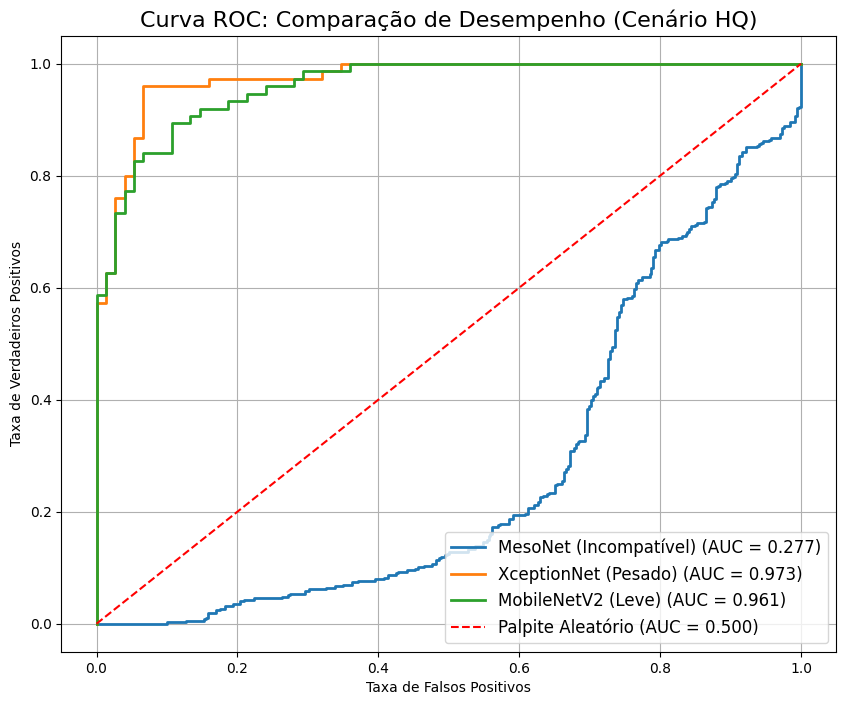


--- ANÁLISE COMPLETA CONCLUÍDA! ---


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import numpy as np
import os

# --- 1. Função para Analisar um CSV ---
def analisar_resultados(csv_file, nome_modelo):
    """Lê um arquivo CSV, calcula as métricas e retorna um dicionário."""
    
    print(f"Carregando e analisando: {nome_modelo} ({csv_file})...")
    
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"--- ERRO: Arquivo não encontrado: {csv_file} ---")
        return None
    
    # Arredonda o score para 0 ou 1
    df['prediction'] = (df['score'] > 0.5).astype(int)
    
    # Separa por cenário
    hq_df = df[df['scenario'] == 'hq']
    lq_df = df[df['scenario'] == 'lq']
    
    if hq_df.empty or lq_df.empty:
        print(f"--- AVISO: Cenários 'hq' ou 'lq' faltando no {nome_modelo} ---")
        # Mesmo que falte um, tentamos calcular o que temos
        acc_hq, auc_hq, acc_lq, auc_lq = 0, 0, 0, 0
        if not hq_df.empty:
             acc_hq = accuracy_score(hq_df['label'], hq_df['prediction'])
             auc_hq = roc_auc_score(hq_df['label'], hq_df['score'])
        if not lq_df.empty:
             acc_lq = accuracy_score(lq_df['label'], lq_df['prediction'])
             auc_lq = roc_auc_score(lq_df['label'], lq_df['score'])
    else:
        # Métricas HQ
        acc_hq = accuracy_score(hq_df['label'], hq_df['prediction'])
        auc_hq = roc_auc_score(hq_df['label'], hq_df['score'])
        # Métricas LQ
        acc_lq = accuracy_score(lq_df['label'], lq_df['prediction'])
        auc_lq = roc_auc_score(lq_df['label'], lq_df['score'])
    
    print(f"Acurácia (HQ): {acc_hq * 100:.2f}% | Acurácia (LQ): {acc_lq * 100:.2f}%")
    print(f"AUC (HQ):      {auc_hq:.4f} | AUC (LQ):      {auc_lq:.4f}")
    print("-" * 30)
    
    return {
        "nome": nome_modelo,
        "acc_hq": acc_hq, "acc_lq": acc_lq,
        "auc_hq": auc_hq, "auc_lq": auc_lq,
        "df": df # Retorna o dataframe para os gráficos
    }

# --- 2. Carregar os Três Modelos ---
print("Iniciando Análise Comparativa de 3 Modelos...")
data_meso = analisar_resultados("results.csv", "MesoNet (Incompatível)")
data_xception = analisar_resultados("results_xception_TRAINADO.csv", "XceptionNet (Pesado)")
data_mobilenet = analisar_resultados("results_mobilenet_TRAINADO.csv", "MobileNetV2 (Leve)")

# Filtra modelos que falharam ao carregar
modelos_carregados = [m for m in [data_meso, data_xception, data_mobilenet] if m is not None]

if len(modelos_carregados) == 0:
    print("Nenhum dado de modelo foi carregado. Saindo.")
else:
    print("\n" + "="*40 + "\nGRÁFICOS SENDO GERADOS...\n" + "="*40)

# --- 3. Gráfico 1: A GRANDE COMPARAÇÃO (Gráfico de Barras) ---
plt.figure(figsize=(14, 8))
labels = ['HQ (Alta Qualidade)', 'LQ (Baixa Qualidade)']
num_modelos = len(modelos_carregados)
width = 0.8 / num_modelos  # Largura da barra baseada no num de modelos
x = np.arange(len(labels))

# Cria as barras para cada modelo
for i, modelo_data in enumerate(modelos_carregados):
    # Calcula o deslocamento para cada barra
    offset = (i - (num_modelos - 1) / 2) * width
    metrics = [modelo_data['acc_hq'], modelo_data['acc_lq']]
    rects = plt.bar(x + offset, metrics, width, label=modelo_data['nome'])
    
    # Coloca os valores % em cima das barras
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height*100:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

plt.ylabel('Acurácia')
plt.title('Comparação de Modelos: Robustez à Compressão', fontsize=18)
plt.xticks(x, labels)
plt.ylim(0, 1.1)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

# --- 4. Gráfico 2: O "RAIO-X" (Histograma de Scores) ---
print("\nGerando Gráfico 2: Histograma de Scores (O Raio-X)...")
# Cria N subplots, onde N é o número de modelos
fig, axes = plt.subplots(1, num_modelos, figsize=(8 * num_modelos, 6), sharey=True)
if num_modelos == 1: axes = [axes] # Torna 'axes' iterável se houver apenas 1
fig.suptitle('Distribuição dos Scores (O "Raio-X" da Confusão do Modelo)', fontsize=20)

for ax, modelo_data in zip(axes, modelos_carregados):
    df_hq = modelo_data['df'][modelo_data['df']['scenario'] == 'hq']
    
    # Plota a distribuição dos 'Reais'
    sns.histplot(df_hq[df_hq['label'] == 0], x='score', kde=True, color='blue', label='Real', ax=ax, stat='density', bins=10)
    # Plota a distribuição dos 'Fakes'
    sns.histplot(df_hq[df_hq['label'] == 1], x='score', kde=True, color='red', label='Fake', ax=ax, stat='density', bins=10)
    
    ax.set_title(f"{modelo_data['nome']} (HQ)")
    ax.legend()
    ax.set_xlabel('Score (Nota do Modelo)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta para o super-título
plt.show()

# --- 5. Gráfico 3: A CURVA ROC (O Padrão-Ouro) ---
print("\nGerando Gráfico 3: Curva ROC (O Padrão-Ouro)...")
plt.figure(figsize=(10, 8))

# Plota a curva para cada modelo
for modelo_data in modelos_carregados:
    # Usamos os dados de HQ para a curva ROC principal
    df_hq = modelo_data['df'][modelo_data['df']['scenario'] == 'hq']
    fpr, tpr, _ = roc_curve(df_hq['label'], df_hq['score'])
    auc = roc_auc_score(df_hq['label'], df_hq['score'])
    plt.plot(fpr, tpr, label=f"{modelo_data['nome']} (AUC = {auc:.3f})", linewidth=2)

# Linha do palpite (moeda)
plt.plot([0, 1], [0, 1], 'r--', label='Palpite Aleatório (AUC = 0.500)')

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC: Comparação de Desempenho (Cenário HQ)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()

print("\n--- ANÁLISE COMPLETA CONCLUÍDA! ---")